# Load Full Data

In [1]:
import polars as pl
from pathlib import Path

def read_aggregated_files(base_path, symbol, interval, year=2025):
    """
    Reads and concatenates aggregated trade data files for a given symbol and interval.

    Parameters:
    - base_path: The base directory where the data is stored.
    - symbol: The trading symbol (e.g., 'BTCUSDT').
    - interval: The aggregation interval (e.g., '15s', '20s', '25s', '30s').
    - year: The year of the data (default is 2024).

    Returns:
    - A concatenated Polars DataFrame containing all the data with consistent Float64 column types.
    """
    # Construct the directory path
    data_dir = Path(base_path) / f"{symbol}_perps" / f"agg_{interval}"
    
    # Generate the list of file paths
    files = [
        data_dir / f"{symbol}-aggTrades-{year}-{month:02d}_aggregated_{interval}.parquet"
        for month in range(1, 13)
    ]
    
    # Read and convert all files to Float64 before concatenation
    dfs = []
    for file in files:
        if file.exists():
            df = pl.read_parquet(file)
            df = df.with_columns([pl.col(col).cast(pl.Float64) for col in df.columns])  # Corrected casting
            dfs.append(df)
    
    # Concatenate vertically
    return pl.concat(dfs) if dfs else pl.DataFrame()

# Example usage
base_path = "/home/ubuntu/Rheza/data/binance_aggtrades"
symbol = "XRPUSDT"
interval = "15s"  # Change this to '15s', '25s', '30s', etc.

dfs = read_aggregated_files(base_path, symbol, interval)
dfs

year,month,day,hour,minute,interval,open,high,low,close
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025.0,1.0,1.0,0.0,0.0,0.0,2.0835,2.0836,2.0812,2.0813
2025.0,1.0,1.0,0.0,0.0,1.0,2.0812,2.0823,2.0808,2.082
2025.0,1.0,1.0,0.0,0.0,2.0,2.082,2.0835,2.082,2.0835
2025.0,1.0,1.0,0.0,0.0,3.0,2.0834,2.0846,2.0831,2.0846
2025.0,1.0,1.0,0.0,1.0,0.0,2.0845,2.0852,2.0832,2.0834
…,…,…,…,…,…,…,…,…,…
2025.0,2.0,28.0,23.0,58.0,3.0,2.1462,2.147,2.1462,2.1465
2025.0,2.0,28.0,23.0,59.0,0.0,2.1465,2.1466,2.1457,2.1458
2025.0,2.0,28.0,23.0,59.0,1.0,2.1458,2.1458,2.144,2.1441


# Features Engineering

In [2]:
import polars as pl

# Compute percentage changes relative to 'open'
dfs_featured = dfs.with_columns([
    ((pl.col("close") - pl.col("open")) / pl.col("open") * 100).cast(pl.Float64).alias("occ"),
    ((pl.col("high") - pl.col("open")) / pl.col("open") * 100).cast(pl.Float64).alias("ohc"),
    ((pl.col("low") - pl.col("open")) / pl.col("open") * 100).cast(pl.Float64).alias("olc"),
    ((pl.col("close").shift(-1) - pl.col("open")) / pl.col("open") * 100).cast(pl.Float64).alias("occ_2"),
    ((pl.col("high").shift(-1) - pl.col("open")) / pl.col("open") * 100).cast(pl.Float64).alias("ohc_2"),
    ((pl.col("low").shift(-1) - pl.col("open")) / pl.col("open") * 100).cast(pl.Float64).alias("olc_2")
])

# Define shift values (now positive)
shifts = [2, 3, 4, 5, 6, 7, 8]

# Compute shifted values and derived features
dfs_featured = dfs_featured.with_columns([
    pl.col("occ").shift(-1).cast(pl.Float64).alias("next_occ"),
    pl.col("open").shift(-1).cast(pl.Float64).alias("next_open"),
    pl.col("close").shift(-1).cast(pl.Float64).alias("next_close"),
] + [
    pl.col("close").shift(-s).cast(pl.Float64).alias(f"next_close_{s}") for s in shifts
]
)

# Remove nulls and return cleaned dataframe
dfs_featured = dfs_featured.drop_nulls()
dfs_featured

year,month,day,hour,minute,interval,open,high,low,close,occ,ohc,olc,occ_2,ohc_2,olc_2,next_occ,next_open,next_close,next_close_2,next_close_3,next_close_4,next_close_5,next_close_6,next_close_7,next_close_8
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025.0,1.0,1.0,0.0,0.0,0.0,2.0835,2.0836,2.0812,2.0813,-0.105592,0.0048,-0.110391,-0.071994,-0.057595,-0.12959,0.038439,2.0812,2.082,2.0835,2.0846,2.0834,2.0833,2.0829,2.0846,2.0851
2025.0,1.0,1.0,0.0,0.0,1.0,2.0812,2.0823,2.0808,2.082,0.038439,0.052854,-0.01922,0.110513,0.110513,0.038439,0.072046,2.082,2.0835,2.0846,2.0834,2.0833,2.0829,2.0846,2.0851,2.086
2025.0,1.0,1.0,0.0,0.0,2.0,2.082,2.0835,2.082,2.0835,0.072046,0.072046,0.0,0.12488,0.12488,0.052834,0.057598,2.0834,2.0846,2.0834,2.0833,2.0829,2.0846,2.0851,2.086,2.086
2025.0,1.0,1.0,0.0,0.0,3.0,2.0834,2.0846,2.0831,2.0846,0.057598,0.057598,-0.0144,0.0,0.086397,-0.0096,-0.05277,2.0845,2.0834,2.0833,2.0829,2.0846,2.0851,2.086,2.086,2.0857
2025.0,1.0,1.0,0.0,1.0,0.0,2.0845,2.0852,2.0832,2.0834,-0.05277,0.033581,-0.062365,-0.057568,-0.014392,-0.067162,-0.009599,2.0835,2.0833,2.0829,2.0846,2.0851,2.086,2.086,2.0857,2.0858
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025.0,2.0,28.0,23.0,56.0,3.0,2.1456,2.1456,2.1451,2.1456,0.0,0.0,-0.023304,-0.032625,0.0,-0.074571,-0.032625,2.1456,2.1449,2.1444,2.1448,2.1454,2.1458,2.1469,2.1463,2.1465
2025.0,2.0,28.0,23.0,57.0,0.0,2.1456,2.1456,2.144,2.1449,-0.032625,0.0,-0.074571,-0.055928,0.0,-0.060589,-0.027972,2.145,2.1444,2.1448,2.1454,2.1458,2.1469,2.1463,2.1465,2.1458
2025.0,2.0,28.0,23.0,57.0,1.0,2.145,2.1456,2.1443,2.1444,-0.027972,0.027972,-0.032634,-0.009324,-0.009324,-0.041958,0.018653,2.1444,2.1448,2.1454,2.1458,2.1469,2.1463,2.1465,2.1458,2.1441


# Checking Matched Criteria

In [13]:
import polars as pl
import itertools
import numpy as np

# Define possible threshold values for each parameter
occ_thresholds = [0.8]
ohc_thresholds = [1.1]
olc_thresholds = [-100]

change_thresholds = [100]

hold_periodes = [8]

# Store results
results = []

# Loop through all combinations of thresholds
for (occ_threshold, ohc_threshold, olc_threshold, change_threshold, hold_periode) in itertools.product(
    occ_thresholds, ohc_thresholds, olc_thresholds, change_thresholds, hold_periodes):

    # Apply filtering logic
    df_test = dfs_featured.with_columns(
        pl.when(
                (pl.col("occ").cast(float) >= occ_threshold) &
                (pl.col("ohc").cast(float) >= ohc_threshold) &
                (pl.col("olc").cast(float) >= olc_threshold)    
        )
        .then(pl.lit("Long"))
        .otherwise(None)
        .alias("action")
    )

    # Define the target columns dynamically
    target_close = f"next_close_{hold_periode}" if hold_periode > 1 else "next_close"

    ##
    # Drop any NaN values **only in df_test_cleaned**
    df_test_cleaned = df_test.drop_nulls()

    # Convert year, month, day, hour, and minute to a datetime column
    df_test_cleaned = df_test_cleaned.with_columns(
        (pl.col("year").cast(pl.Int32).cast(pl.Utf8) + "-" + 
        pl.col("month").cast(pl.Int32).cast(pl.Utf8).str.zfill(2) + "-" + 
        pl.col("day").cast(pl.Int32).cast(pl.Utf8).str.zfill(2) + " " + 
        pl.col("hour").cast(pl.Int32).cast(pl.Utf8).str.zfill(2) + ":" + 
        pl.col("minute").cast(pl.Int32).cast(pl.Utf8).str.zfill(2))
        .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M", strict=False)
        .alias("datetime")
    )

    # Add interval (each interval is 15 seconds in milliseconds)
    df_test_cleaned = df_test_cleaned.with_columns(
        (pl.col("datetime") + (pl.col("interval") * 15_000).cast(pl.Duration("ms"))).alias("datetime")
    )

    # Add interval (each interval is 15 seconds in milliseconds)
    df_test_cleaned = df_test_cleaned.with_columns(
        (pl.col("datetime") + (pl.col("interval") * 15_000 * hold_periode).cast(pl.Duration("ms"))).alias("estimated_closetime")
    )

    # Select relevant columns
    df_test_cleaned = df_test_cleaned.select(["action", "datetime", "year", "month", "day", "hour", "minute",
                                            "occ", "ohc", "olc", "next_open", "estimated_closetime", target_close])

    # Rename the last column to 'target_price'
    df_test_cleaned = df_test_cleaned.rename({df_test_cleaned.columns[-1]: "target_price"})

    # Ensure DataFrame is sorted
    df_test_cleaned = df_test_cleaned.sort("datetime")

    # Convert to list of dictionaries for iterative processing
    df_list = df_test_cleaned.to_dicts()
    merged_list = []

    i = 0
    while i < len(df_list):
        current_row = df_list[i]
        
        # Check if the next row exists
        while i + 1 < len(df_list) and df_list[i + 1]["datetime"] < current_row["estimated_closetime"]:
            next_row = df_list[i + 1]
            
            # Merge logic: Keep all values from the current row except estimated_closetime and target_price
            current_row["estimated_closetime"] = next_row["estimated_closetime"]
            current_row["target_price"] = next_row["target_price"]
            
            # Move to the next row (merging step)
            i += 1

        # Append the merged row
        merged_list.append(current_row)
        i += 1  # Move to the next unmerged row

    # Convert back to Polars DataFrame
    df_merged = pl.DataFrame(merged_list)

    df_sum = df_merged.with_columns(
    pl.when(pl.col("action") == "Long")
    .then(
        pl.when(((pl.col("target_price") - pl.col("next_open")) / pl.col("next_open") * 100) >= change_threshold)
        .then(pl.lit(change_threshold - 0.04))
        .otherwise(((pl.col("target_price") - pl.col("next_open")) / pl.col("next_open") * 100) - 0.1))
    .alias("pnl")
    )

    # Calculate metrics
    total_pnl = df_sum["pnl"].sum()
    total_long = len(df_sum)
    total_wins = df_sum.filter((pl.col("pnl") >= 0)).height
    win_rate = (total_wins / total_long) * 100 if total_long > 0 else 0

print(f"Metrics | occ: {occ_thresholds}, ohc: {ohc_thresholds}, hold: {hold_periode}")
print(f"Long Opened: {total_long}")
print(f"Winrate: {win_rate} %")
print(f"Total PnL: {total_pnl} %")

Metrics | occ: [0.8], ohc: [1.1], hold: 8
Long Opened: 36
Winrate: 66.66666666666666 %
Total PnL: 8.796952985054409 %


# Trade Summary

In [14]:
df_sum

action,datetime,year,month,day,hour,minute,occ,ohc,olc,next_open,estimated_closetime,target_price,pnl
str,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],f64,f64
"""Long""",2025-01-07 15:16:00,2025.0,1.0,7.0,15.0,16.0,1.217118,1.221481,-0.14396,2.3201,2025-01-07 15:16:00,2.3283,0.253433
"""Long""",2025-01-13 14:40:30,2025.0,1.0,13.0,14.0,40.0,0.871757,1.11965,-0.066105,2.4416,2025-01-13 14:44:30,2.4392,-0.198296
"""Long""",2025-01-15 13:30:00,2025.0,1.0,15.0,13.0,30.0,2.19934,2.350029,-0.035878,2.8484,2025-01-15 13:30:00,2.8289,-0.784595
"""Long""",2025-01-15 15:10:30,2025.0,1.0,15.0,15.0,10.0,1.400355,1.717351,-0.024384,2.9108,2025-01-15 15:14:30,2.9379,0.831016
"""Long""",2025-01-15 15:29:15,2025.0,1.0,15.0,15.0,29.0,1.218614,1.640442,-0.026783,3.0232,2025-01-15 15:31:15,2.9661,-1.988727
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Long""",2025-02-03 14:38:00,2025.0,2.0,3.0,14.0,38.0,0.905171,1.105845,-0.055506,2.3635,2025-02-03 14:38:00,2.3766,0.454263
"""Long""",2025-02-07 13:30:00,2025.0,2.0,7.0,13.0,30.0,1.102895,1.224046,-0.029243,2.4198,2025-02-07 13:30:00,2.4018,-0.843863
"""Long""",2025-02-13 13:30:00,2025.0,2.0,13.0,13.0,30.0,1.113897,1.167331,0.0,2.4592,2025-02-13 13:30:00,2.4368,-1.010865


In [15]:
df_sum = df_sum.select(["datetime", "year", "month", "day", "hour", "minute", "action", "pnl"])
df_sum = df_sum.with_columns(
        pl.when(
            (pl.col("pnl") >= 0)
        )
        .then(1)
        .otherwise(0)
        .alias("win")
    )
df_sum

datetime,year,month,day,hour,minute,action,pnl,win
datetime[μs],f64,f64,f64,f64,f64,str,f64,i32
2025-01-07 15:16:00,2025.0,1.0,7.0,15.0,16.0,"""Long""",0.253433,1
2025-01-13 14:40:30,2025.0,1.0,13.0,14.0,40.0,"""Long""",-0.198296,0
2025-01-15 13:30:00,2025.0,1.0,15.0,13.0,30.0,"""Long""",-0.784595,0
2025-01-15 15:10:30,2025.0,1.0,15.0,15.0,10.0,"""Long""",0.831016,1
2025-01-15 15:29:15,2025.0,1.0,15.0,15.0,29.0,"""Long""",-1.988727,0
…,…,…,…,…,…,…,…,…
2025-02-03 14:38:00,2025.0,2.0,3.0,14.0,38.0,"""Long""",0.454263,1
2025-02-07 13:30:00,2025.0,2.0,7.0,13.0,30.0,"""Long""",-0.843863,0
2025-02-13 13:30:00,2025.0,2.0,13.0,13.0,30.0,"""Long""",-1.010865,0


In [16]:
import polars as pl

# Group by year and month, then aggregate
df_monthly = df_sum.group_by(['year', 'month']).agg([
    pl.col('action').count().alias('action_count'),
    pl.col('pnl').sum().alias('cum_pnl'),
    pl.col('win').sum().alias('sum_win'),
])

df_monthly = df_monthly.with_columns(
        ((pl.col("sum_win") / pl.col("action_count")) * 100).alias("win_rate")
    )

# Display the result
df_monthly

year,month,action_count,cum_pnl,sum_win,win_rate
f64,f64,u32,f64,i32,f64
2025.0,2.0,23,8.260442,16,69.565217
2025.0,1.0,13,0.536511,8,61.538462


In [17]:
import polars as pl

# Group by year and month, then aggregate
df_hourly = df_sum.group_by(['hour']).agg([
    pl.col('action').count().alias('action_count'),
    pl.col('pnl').sum().alias('cum_pnl'),
    pl.col('win').sum().alias('sum_win'),
])

df_hourly = df_hourly.with_columns(
        ((pl.col("sum_win") / pl.col("action_count")) * 100).alias("win_rate")
    )

# Display the result
df_hourly

hour,action_count,cum_pnl,sum_win,win_rate
f64,u32,f64,i32,f64
3.0,1,0.280466,1,100.0
11.0,1,0.166362,1,100.0
22.0,2,0.092335,1,50.0
17.0,2,-0.014532,1,50.0
15.0,3,-0.904279,2,66.666667
…,…,…,…,…
13.0,5,-3.857637,0,0.0
2.0,7,10.847552,6,85.714286
7.0,2,1.50274,2,100.0


# Plot

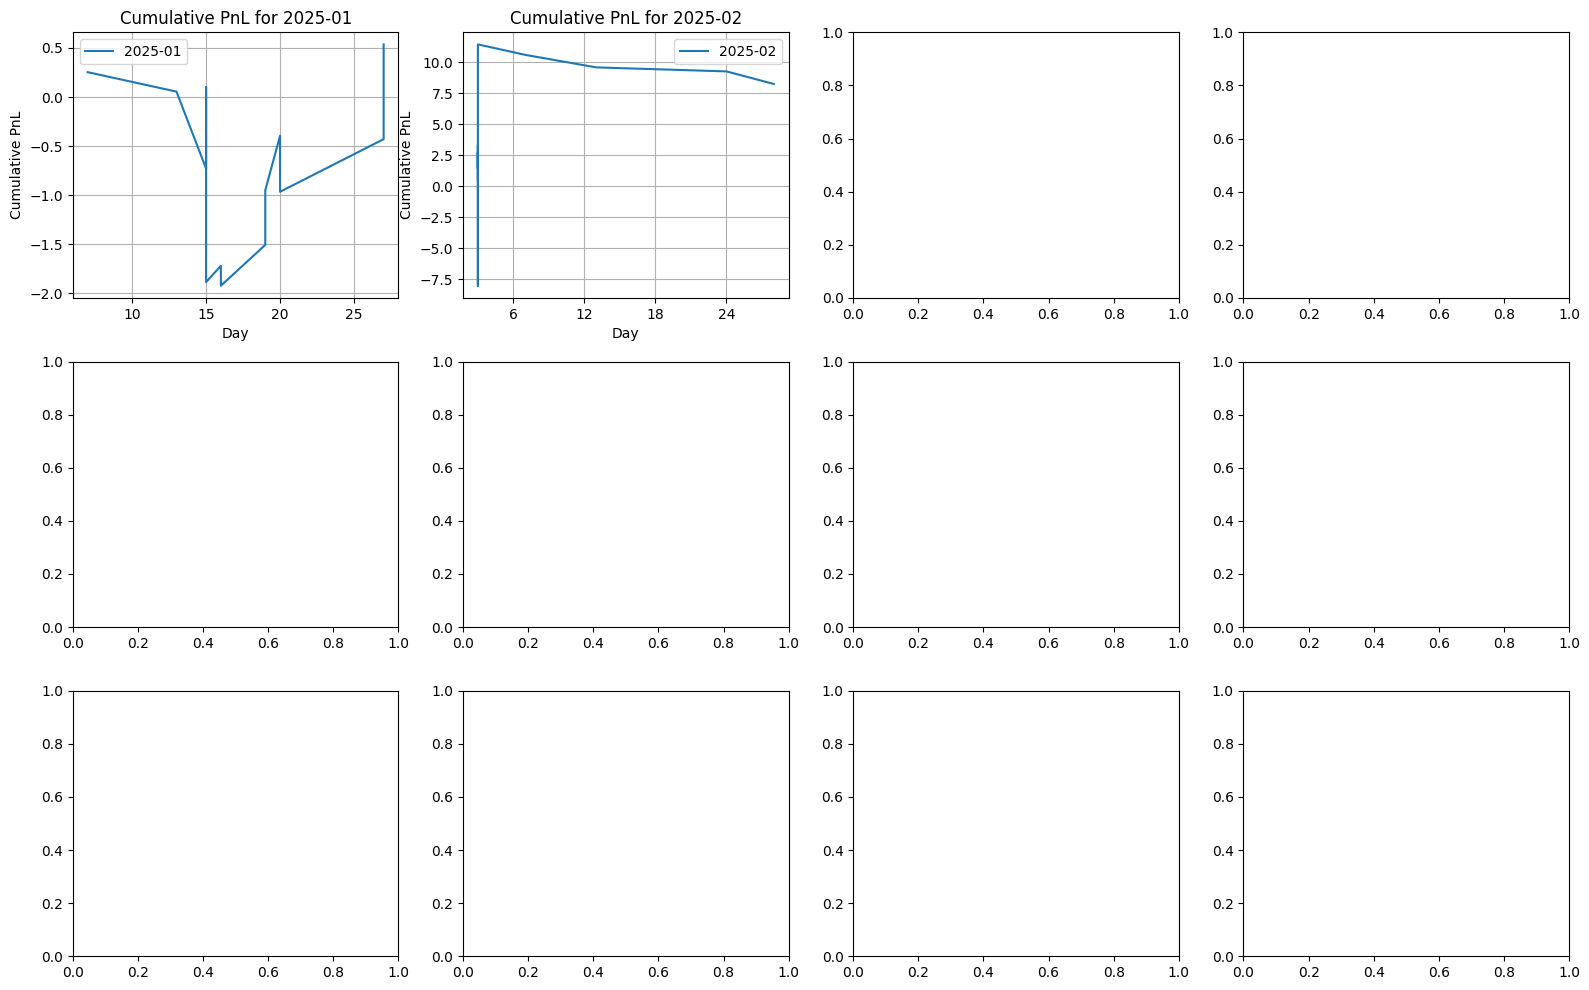

In [18]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Convert datetime column to Polars datetime type if not already
df_sum = df_sum.with_columns(pl.col("datetime").cast(pl.Datetime))

# Group by year and month
df_months = df_sum.group_by(["year", "month"], maintain_order=True)

# Create subplots (3 rows, 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# Loop through each group
for i, (year_month, df) in enumerate(df_months):
    year, month = year_month  # Unpack tuple (year, month)

    # Sort by datetime
    df = df.sort("datetime")

    # Compute cumulative PnL per month (starting from 0)
    df = df.with_columns(pl.col("pnl").cum_sum().alias("cum_pnl"))

    # Extract day (DD) for x-axis labels
    df = df.with_columns(df["datetime"].dt.day().alias("day"))

    # Plot
    ax = axes[i]
    ax.plot(df["day"].to_list(), df["cum_pnl"].to_list(), linestyle="-", label=f"{int(year)}-{int(month):02d}")
    ax.set_title(f"Cumulative PnL for {int(year)}-{int(month):02d}")
    ax.set_xlabel("Day")
    ax.set_ylabel("Cumulative PnL")
    ax.legend()
    ax.grid(True)

    # Reduce the number of x-axis labels
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Show only 5 labels

# Adjust layout and show
plt.tight_layout()
plt.show()

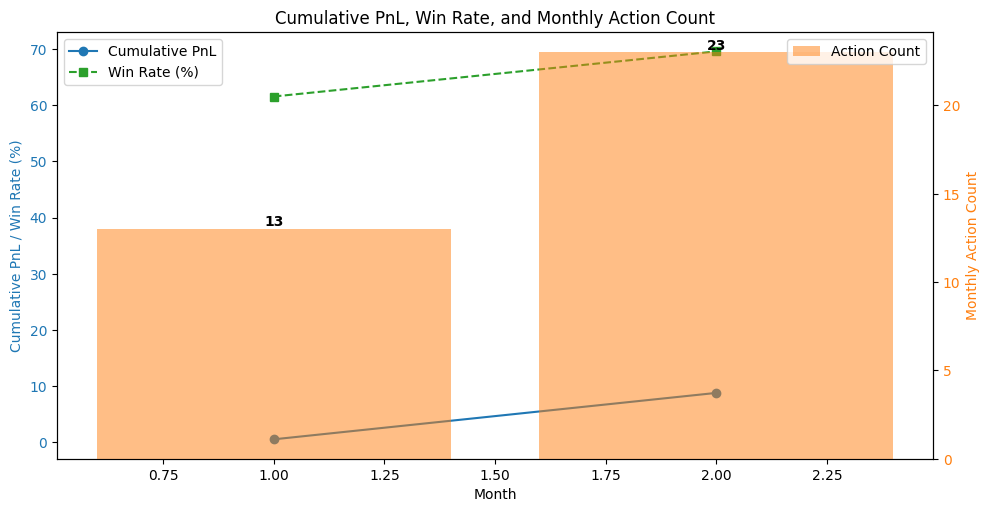

In [19]:
import matplotlib.pyplot as plt

# Ensure the data is sorted by month
df_monthly = df_monthly.sort("month")

# Compute cumulative PnL correctly in Polars
df_monthly = df_monthly.with_columns((df_monthly["cum_pnl"].cum_sum()).alias("cumulative_pnl"))

fig, ax1 = plt.subplots(figsize=(10, 5))

# First y-axis: Cumulative PnL and Win Rate
ax1.set_xlabel("Month")
ax1.set_ylabel("Cumulative PnL / Win Rate (%)", color="tab:blue")
ax1.plot(df_monthly["month"], df_monthly["cumulative_pnl"], marker="o", color="tab:blue", label="Cumulative PnL")
ax1.plot(df_monthly["month"], df_monthly["win_rate"], marker="s", linestyle="dashed", color="tab:green", label="Win Rate (%)")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second y-axis: Monthly Action Count (as bar chart with labels)
ax2 = ax1.twinx()
ax2.set_ylabel("Monthly Action Count", color="tab:orange")
bars = ax2.bar(df_monthly["month"], df_monthly["action_count"], alpha=0.5, color="tab:orange", label="Action Count")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Add text labels on top of each bar
for bar, count in zip(bars, df_monthly["action_count"]):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{count}", 
             ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

# Add legends for clarity
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.title("Cumulative PnL, Win Rate, and Monthly Action Count")
plt.show()

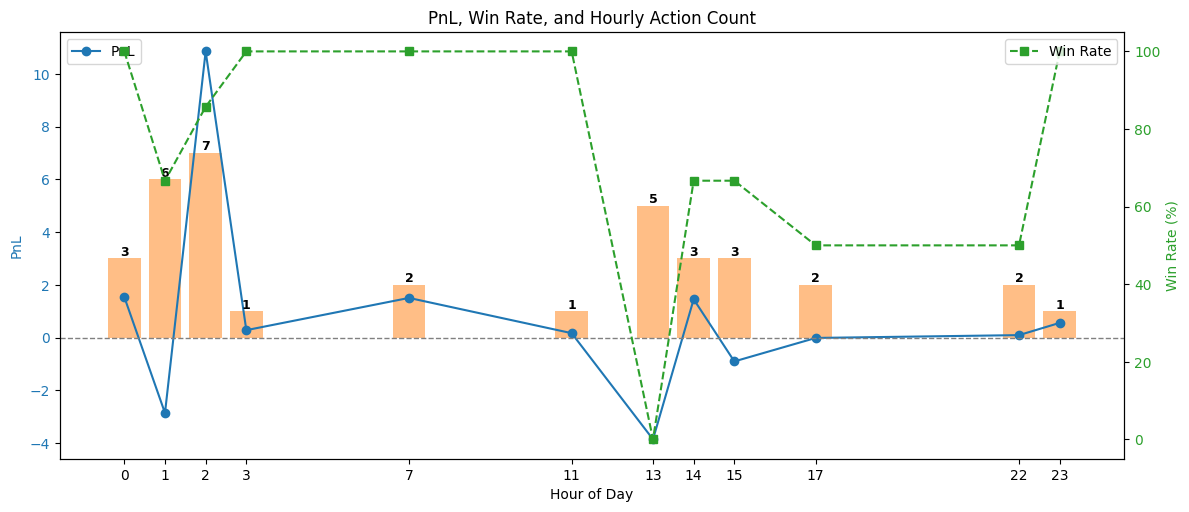

In [20]:
import matplotlib.pyplot as plt

# Ensure the data is sorted by hour
df_hourly = df_hourly.sort("hour")

fig, ax1 = plt.subplots(figsize=(12, 5))

# First y-axis (left): PnL
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("PnL", color="tab:blue")
ax1.plot(df_hourly["hour"], df_hourly["cum_pnl"], marker="o", color="tab:blue", label="PnL")
ax1.axhline(0, linestyle="dashed", color="gray", linewidth=1)  # Add horizontal dashed line at PnL = 0
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second y-axis (right): Win Rate
ax2 = ax1.twinx()
ax2.set_ylabel("Win Rate (%)", color="tab:green")
ax2.plot(df_hourly["hour"], df_hourly["win_rate"], marker="s", linestyle="dashed", color="tab:green", label="Win Rate")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Action Count as Bars (without axis)
bars = ax1.bar(df_hourly["hour"], df_hourly["action_count"], alpha=0.5, color="tab:orange")

# Add text labels on top of each bar for action count
for bar, count in zip(bars, df_hourly["action_count"]):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{count}", 
             ha="center", va="bottom", fontsize=9, color="black", fontweight="bold")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.title("PnL, Win Rate, and Hourly Action Count")
plt.xticks(df_hourly["hour"])  # Ensure all hours are visible on x-axis
plt.show()

# Filtered Summary

In [21]:
df_sum_filtered = df_sum.filter(~pl.col("hour").is_in([13]))

# Calculate metrics
total_pnl = df_sum_filtered["pnl"].sum()
total_long = len(df_sum_filtered)
total_wins = df_sum_filtered.filter((pl.col("pnl") >= 0)).height
win_rate = (total_wins / total_long) * 100 if total_long > 0 else 0

print(f"Long Opened: {total_long}")
print(f"Win Rate: {win_rate:.2f} %")
print(f"Total PnL: {total_pnl:.2f} %")

Long Opened: 31
Win Rate: 77.42 %
Total PnL: 12.65 %


In [46]:
import polars as pl

# Group by year and month, then aggregate
df_monthly_filtered = df_sum_filtered.group_by(['year', 'month']).agg([
    pl.col('action').count().alias('action_count'),
    pl.col('pnl').sum().alias('cum_pnl'),
    pl.col('win').sum().alias('sum_win'),
])

df_monthly_filtered = df_monthly_filtered.with_columns(
        ((pl.col("sum_win") / pl.col("action_count")) * 100).alias("win_rate")
    )

# Display the result
df_monthly_filtered

year,month,action_count,cum_pnl,sum_win,win_rate
f64,f64,u32,f64,i32,f64
2025.0,2.0,77,5.023565,34,44.155844
2025.0,1.0,33,1.94504,21,63.636364


In [47]:
import polars as pl

# Group by year and month, then aggregate
df_hourly_filtered = df_sum_filtered.group_by(['hour']).agg([
    pl.col('action').count().alias('action_count'),
    pl.col('pnl').sum().alias('cum_pnl'),
    pl.col('win').sum().alias('sum_win'),
])

df_hourly_filtered = df_hourly_filtered.with_columns(
        ((pl.col("sum_win") / pl.col("action_count")) * 100).alias("win_rate")
    )

# Display the result
df_hourly_filtered

hour,action_count,cum_pnl,sum_win,win_rate
f64,u32,f64,i32,f64
10.0,1,0.616642,1,100.0
2.0,29,-3.45507,10,34.482759
20.0,3,0.043609,1,33.333333
12.0,2,-1.001227,0,0.0
1.0,9,4.445882,5,55.555556
…,…,…,…,…
8.0,1,-0.219671,0,0.0
21.0,2,-1.023211,0,0.0
9.0,1,-0.610487,0,0.0


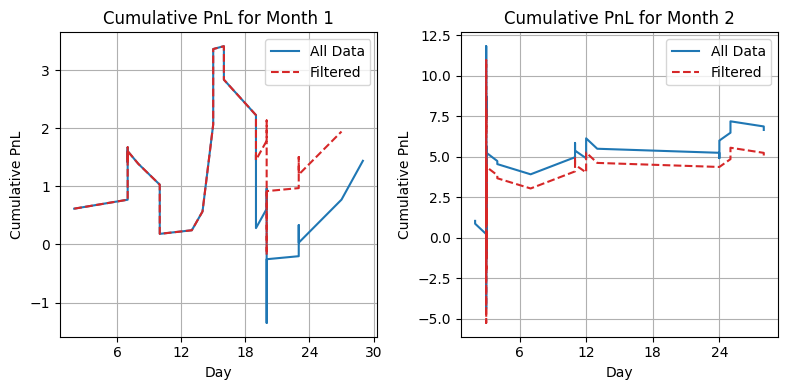

In [48]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Convert datetime column to Polars datetime type if not already
df_sum = df_sum.with_columns(pl.col("datetime").cast(pl.Datetime))
df_sum_filtered = df_sum_filtered.with_columns(pl.col("datetime").cast(pl.Datetime))

# Group by month
df_months = df_sum.group_by("month", maintain_order=True)
df_months_filtered = df_sum_filtered.group_by("month", maintain_order=True)

# Get unique months for subplots
unique_months = df_sum["month"].unique().to_list()
num_months = len(unique_months)

# Create subplots dynamically based on the number of months
rows = (num_months // 4) + (num_months % 4 > 0)  # 4 columns per row
fig, axes = plt.subplots(rows, 4, figsize=(16, 4 * rows))
axes = axes.flatten()

# Loop through each month and plot both datasets
for i, ((month_tuple, df), (_, df_filtered)) in enumerate(zip(df_months, df_months_filtered)):
    month = month_tuple[0]  # Unpack the tuple to get the month value

    # Sort by datetime
    df = df.sort("datetime")
    df_filtered = df_filtered.sort("datetime")

    # Compute cumulative PnL per month
    df = df.with_columns(pl.col("pnl").cum_sum().alias("cum_pnl"))
    df_filtered = df_filtered.with_columns(pl.col("pnl").cum_sum().alias("cum_pnl"))

    # Extract day (DD) for x-axis labels
    df = df.with_columns(df["datetime"].dt.day().alias("day"))
    df_filtered = df_filtered.with_columns(df_filtered["datetime"].dt.day().alias("day"))

    # Plot
    ax = axes[i]
    ax.plot(df["day"].to_list(), df["cum_pnl"].to_list(), linestyle="-", color="tab:blue", label="All Data")
    ax.plot(df_filtered["day"].to_list(), df_filtered["cum_pnl"].to_list(), linestyle="dashed", color="tab:red", label="Filtered")

    ax.set_title(f"Cumulative PnL for Month {int(month)}")
    ax.set_xlabel("Day")
    ax.set_ylabel("Cumulative PnL")
    ax.legend()
    ax.grid(True)

    # Reduce the number of x-axis labels
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Show only 5 labels

# Remove unused subplots if there are fewer than 4*rows
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show
plt.tight_layout()
plt.show()

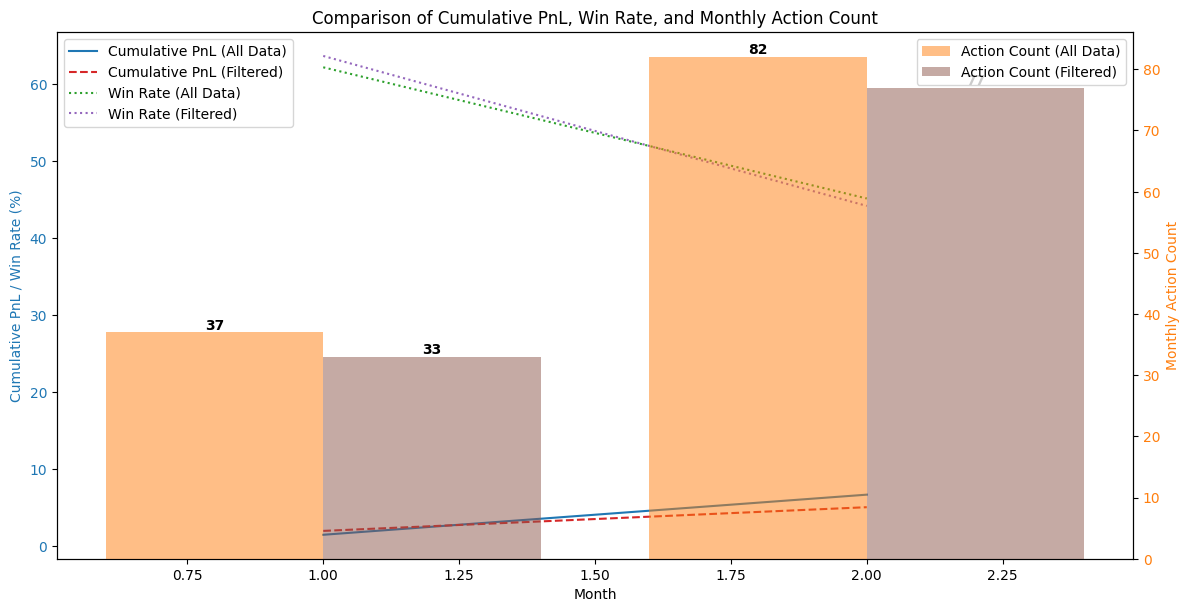

In [49]:
import matplotlib.pyplot as plt

# Ensure both datasets are sorted by month
df_monthly = df_monthly.sort("month")
df_monthly_filtered = df_monthly_filtered.sort("month")

fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis: Cumulative PnL and Win Rate
ax1.set_xlabel("Month")
ax1.set_ylabel("Cumulative PnL / Win Rate (%)", color="tab:blue")

# Cumulative PnL comparison
ax1.plot(df_monthly["month"], df_monthly["cum_pnl"], linestyle="-", color="tab:blue", label="Cumulative PnL (All Data)")
ax1.plot(df_monthly_filtered["month"], df_monthly_filtered["cum_pnl"], linestyle="dashed", color="tab:red", label="Cumulative PnL (Filtered)")

# Win Rate comparison
ax1.plot(df_monthly["month"], df_monthly["win_rate"], linestyle="dotted", color="tab:green", label="Win Rate (All Data)")
ax1.plot(df_monthly_filtered["month"], df_monthly_filtered["win_rate"], linestyle="dotted", color="tab:purple", label="Win Rate (Filtered)")

ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second y-axis: Monthly Action Count
ax2 = ax1.twinx()
ax2.set_ylabel("Monthly Action Count", color="tab:orange")

# Bar chart comparison for action count
bar_width = 0.4  # Adjust for spacing
bars1 = ax2.bar(df_monthly["month"] - 0.2, df_monthly["action_count"], width=bar_width, alpha=0.5, color="tab:orange", label="Action Count (All Data)")
bars2 = ax2.bar(df_monthly_filtered["month"] + 0.2, df_monthly_filtered["action_count"], width=bar_width, alpha=0.5, color="tab:brown", label="Action Count (Filtered)")

ax2.tick_params(axis="y", labelcolor="tab:orange")

# Add text labels on top of bars for action counts
for bar, count in zip(bars1, df_monthly["action_count"]):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{count}", 
             ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

for bar, count in zip(bars2, df_monthly_filtered["action_count"]):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{count}", 
             ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

# Add legends for clarity
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.title("Comparison of Cumulative PnL, Win Rate, and Monthly Action Count")
plt.show()